In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import logging

In [2]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from sklearn.model_selection import GridSearchCV

In [29]:
logging.basicConfig(level = logging.DEBUG)

logger = logging.getLogger(__name__)

filehandler = logging.FileHandler('STOCK_PREDICTION.log')
formater = logging.Formatter('%(asctime)-15s %(user)-8s %(message)s')
filehandler.setFormatter(formater)

logger.addHandler(filehandler)

In [30]:
init_data = pd.read_csv("TATASTEEL.NS .csv")
print(init_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 7 columns):
Date         2694 non-null object
Open         2681 non-null float64
High         2681 non-null float64
Low          2681 non-null float64
Close        2681 non-null float64
Adj Close    2681 non-null float64
Volume       2681 non-null float64
dtypes: float64(6), object(1)
memory usage: 147.5+ KB
None


In [31]:
init_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2.681000e+03
mean,433.616820,440.183153,426.422516,433.026507,381.626018,6.866629e+06
std,126.519832,127.561919,125.207377,126.301668,119.260351,4.083475e+06
min,142.910995,151.341995,141.671997,144.625000,109.650978,0.000000e+00
25%,346.938995,352.178986,340.269989,346.463013,300.818573,4.202350e+06
50%,427.588013,434.829010,419.200012,427.063995,364.043365,5.853219e+06
75%,534.390015,541.677979,527.005981,533.198975,464.282532,8.319283e+06
max,745.755005,755.520020,734.797974,746.468994,714.714783,5.185835e+07


In [32]:
data = init_data.drop(["Adj Close"], axis=1).copy()
print(data.head(10))

         Date        Open        High         Low       Close      Volume
0  2009-01-02  218.701004  224.559998  216.270996  218.748001   5579516.0
1  2009-01-05  221.796997  236.279007  221.606995  233.992004   7901583.0
2  2009-01-06  233.419998  242.947998  226.942001  235.373993   7856935.0
3  2009-01-07  238.279007  248.378006  219.128998  222.701996  10521837.0
4  2009-01-09  219.128998  224.845993  198.360001  204.837997   8807182.0
5  2009-01-12  202.742004  206.220001  188.975006  190.690002   7365777.0
6  2009-01-13  186.832001  198.169006  181.973007  192.929001   8848654.0
7  2009-01-14  197.216003  205.505005  195.787003  203.028000   5342200.0
8  2009-01-15  196.264008  196.264008  186.117004  188.356003   7912608.0
9  2009-01-16  190.546997  198.169006  182.544006  194.406006   9753831.0


In [33]:
data["Date"] = pd.to_datetime(data["Date"])
print(data.isna().sum())

Date       0
Open      13
High      13
Low       13
Close     13
Volume    13
dtype: int64


In [34]:
data.fillna(value="nan", inplace=True)

In [35]:
def avg(data):
    for i in range(len(data)):
        if data[i] == "nan":
            data[i] = (data[i-1] + data[i-2] + data[i-3])/3
        
    return data

In [36]:
for itr in ['Open', 'Close', 'High', 'Low']:
        avg(data[itr])
    

C:\Users\varun\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
print(data.isna().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


# VISUALIZATION

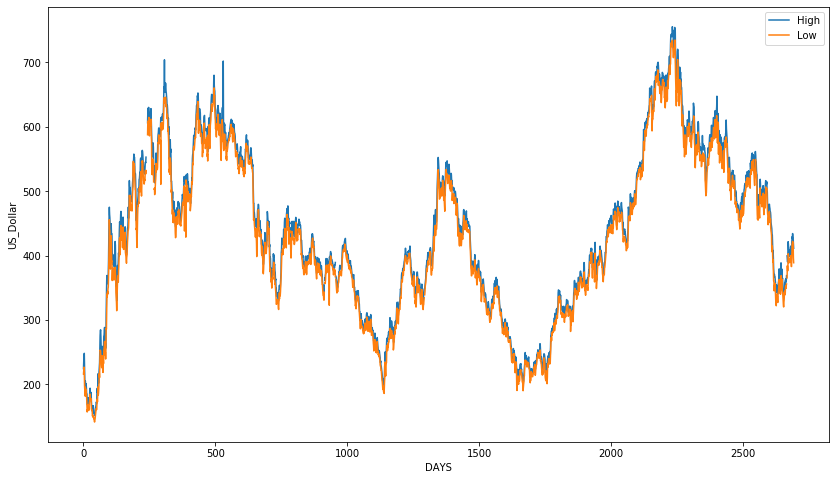

In [38]:
plt.figure(figsize=(14, 8))
plt.plot('High', data=init_data)
plt.plot('Low', data=init_data)
plt.xlabel("DAYS")
plt.ylabel("US_Dollar")
plt.legend()

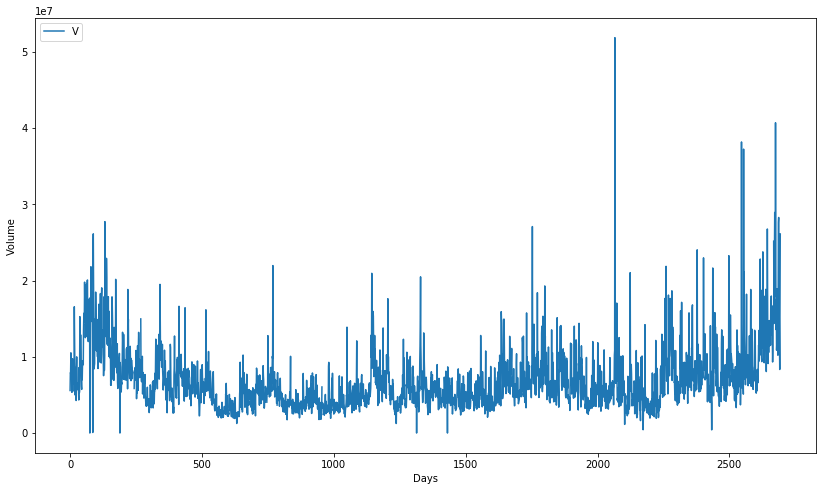

In [12]:
plt.figure(figsize=(14,8))
plt.plot(data["Volume"])
plt.ylabel("Volume")
plt.xlabel("Days")
plt.legend("V",loc="upper left")

In [13]:
params = {"time_steps":60, 
          "batch_size":30, 
          "learning_rate":0.001, 
          "epochs":30}
y_col = 3
OUTPUT_PATH = "C:\\Users\\varun\\Documents\\Projects\\Stock-Market-Prediction"

In [14]:
def build_series(mat, y_col, time_stamp):
    
    dim0 = mat.shape[0] - time_stamp
    dim1 = mat.shape[1]
    
    x = np.zeros((dim0,time_stamp,dim1))
    y = np.zeros((dim0))
     
    for itr in range(dim0):
        x[itr] = mat[itr:time_stamp+itr]
        y[itr] = mat[time_stamp+itr, y_col]
        
    return x,y

In [15]:
def trim_series(mat, batch):
    
    no_of_row_remined = mat.shape[0]%batch
    
    if no_of_row_remined != 0 :
        mat = mat[:-no_of_row_remined]
        
    return mat

In [16]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

In [17]:
    train_cols = data.columns[1:]
    print(train_cols)

    #min_max = MinMaxScaler()
    #norm_data = min_max.fit_transform(data[train_cols])
    
    df_train, df_test = train_test_split(data[train_cols].values, test_size=0.2, train_size=0.8, shuffle=False)
    
    X_train, y_train = build_series(df_train, y_col, params["time_steps"])
    
    X_train = trim_series(X_train, params["batch_size"])
    y_train = trim_series(y_train, params["batch_size"])
    
    X_test, y_test = build_series(df_test, y_col, params["time_steps"])
    
    x_test_val, x_test_t  = np.split(trim_series(X_test, params["batch_size"]),2)
    y_test_val, y_test_t  = np.split(trim_series(y_test, params["batch_size"]),2)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [26]:
X_train[1] == 0

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, Fal

In [18]:
import tensorflow as tf
import tensorflow.keras as k
import os
import sys
sys.executable

'c:\\program files\\python37\\python.exe'

In [19]:
from tensorflow.keras.callbacks import Callback

In [21]:
model = k.models.Sequential()
    
model.add(k.layers.LSTM(100, batch_input_shape=(params["batch_size"], params["time_steps"], 5), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
model.add(k.layers.Dropout(0.4))
model.add(k.layers.Dense(16,activation='relu'))
model.add(k.layers.Dense(1,activation='sigmoid'))
    
optimizer = k.optimizers.RMSprop(learning_rate=params['learning_rate'])
    
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [22]:
model.weights

[<tf.Variable 'lstm/kernel:0' shape=(5, 400) dtype=float32, numpy=
 array([[ 0.03339956,  0.01044134,  0.04825074, ..., -0.02405681,
          0.04131854, -0.02846896],
        [ 0.04800645, -0.0119933 , -0.02640153, ...,  0.04358393,
         -0.04085379,  0.03568633],
        [ 0.01232033, -0.00140136,  0.01850542, ...,  0.02982669,
          0.00198596, -0.02489345],
        [-0.02931889, -0.02072837,  0.02082873, ..., -0.01869269,
         -0.0140115 , -0.01584889],
        [-0.04822308,  0.01095913, -0.01437201, ..., -0.02695822,
         -0.02819704, -0.01619891]], dtype=float32)>,
 <tf.Variable 'lstm/recurrent_kernel:0' shape=(100, 400) dtype=float32, numpy=
 array([[ 0.0175668 ,  0.08699201, -0.05606735, ..., -0.09992059,
          0.01007972, -0.0516233 ],
        [ 0.06982919,  0.01204765, -0.01507706, ...,  0.06976823,
          0.1290917 , -0.05287135],
        [-0.03732526, -0.04291224, -0.03904104, ...,  0.00253574,
          0.12224123, -0.02991245],
        ...,
       

In [23]:
csv_logger = k.callbacks.CSVLogger(os.path.join(OUTPUT_PATH, 'Accuracy' + '.log'), append=True)
    
history = model.fit(X_train, y_train, epochs=params["epochs"], verbose=2, batch_size=params["batch_size"],
                 shuffle=False, validation_data=(trim_series(x_test_val, params["batch_size"]),
                 trim_series(y_test_val, params["batch_size"])))

Train on 2070 samples, validate on 210 samples
Epoch 1/30
2070/2070 - 6s - loss: nan - val_loss: nan
Epoch 2/30


KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(trim_series(x_test_t,batch=params["batch_size"]),batch_size=params["batch_size"])

error = k.metrics.mean_squared_error(y_test_t,y_pred)

In [ ]:
plt.plot(error)

In [ ]:
y_pred_org = (y_pred * min_max.data_range_[3]) + min_max.data_min_[3]
y_test_org = (y_test_t * min_max.data_range_[3]) + min_max.data_min_[3]

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Iteration")
plt.ylabel("Error")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_pred_org)
plt.plot(y_test_org)

# BAYESIEN OPTIMIZATION

In [ ]:

def Data(data, params):
    
    train_cols = data.columns[1:]
    print(train_cols)

    min_max = MinMaxScaler()
    norm_data = min_max.fit_transform(data[train_cols])
    
    X_train, X_test = train_test_split(norm_data, test_size=0.2, train_size=0.8, shuffle=False)
    
    x_t, y_t = build_series(X_train, y_col, params["time_steps"])
    x_t = trim_series(x_t, params["batch_size"])
    y_t = trim_series(y_t, params["batch_size"])
    x_test, y_test = build_series(X_test, y_col, params["time_steps"])
    x_test  = trim_series(x_test, params["batch_size"])
    y_test  = trim_series(y_test, params["batch_size"])
    
    return x_t, y_t, x_test, y_test


In [ ]:
def Search_Space():
    
    search_space = {
    'batch_size': hp.choice('bs', [30,40,50,60,70]),
    'time_steps': hp.choice('ts', [30,50,60,80,90]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [15]),
    "optimizer": hp.choice('optmz',["sgd", "rms"])}
    
    return search_space

In [ ]:

def create_model_hypopt(params):
    print("Trying params:",params)
    
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = Data(data, params)
    
    lstm_model = k.models.Sequential()
    
    lstm_model.add(k.layers.LSTM(100, batch_input_shape=(batch_size, time_steps, x_train_ts.shape[2]), dropout=0,
                        recurrent_dropout=0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))  
    lstm_model.add(k.layers.LSTM(32, dropout=0.4))
    lstm_model.add(k.layers.Dense(8, activation='relu'))
    lstm_model.add(k.layers.Dense(1, activation='sigmoid'))

    lr = params["lr"]
    epochs = params["epochs"]
    
    if params["optimizer"] == 'rms':
        optimizer = k.optimizers.RMSprop(lr=lr)
    else:
        optimizer = k.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    csv_logger = k.callbacks.CSVLogger(os.path.join(OUTPUT_PATH, 'STOCK_PREDICTION' + '.log'), append=True)
    
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=epochs, verbose=2, batch_size=batch_size,
                             validation_data=[x_test_ts, y_test_ts], callbacks =[csv_logger] )
   
    val_error = np.amin(history.history['val_loss'])
    
    print('Best validation error of epoch:', val_error)
    
    return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model}


In [ ]:

def Bayseien_Optimization(data): 
    
    search_space = Search_Space()
        
    trials = Trials()

    best = fmin(create_model_hypopt, space=search_space,algo=tpe.suggest,max_evals=10, trials=trials)
    
    return best


In [ ]:
Bayseien_Optimization(data)

# GRID SEARCH

In [ ]:
def Model(params):
    model = k.models.Sequential()
    
    model.add(k.layers.LSTM(128, batch_input_shape=(params["batch_size"], params["time_steps"], 5), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    model.add(k.layers.Dropout(0.2))
    model.add(k.layers.Dense(64,activation='relu'))
    model.add(k.layers.Dense(1,activation='sigmoid'))
    
    optimizer = k.optimizers.RMSprop(learning_rate=params['learning_rate'])
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:

def Grid_Search(Model, params, x_t, y_t):
    
    parameters = dict(epochs = [10, 20, 30], batch_size = [20, 60, 90], learning_rate = [0.1, 0.01, 0.001], time_steps = [60, 90, 30])

    model_grid = k.wrappers.scikit_learn.KerasRegressor(build_fn=Model, params=params)

    grid = GridSearchCV(estimator=model_grid, param_grid=parameters, cv=3)

    grid_result = grid.fit(x_t, y_t)
    
    return grid_result


In [ ]:
Grid_Search(Model,params, X_train, y_train)